<a href="https://colab.research.google.com/github/kwcooper/CL_neuromatch/blob/main/continual_learning_neuromatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week ?, Day ?, Tutorial ?
# Introduction to Continual Learning

__Content creators:__ [Keiland Cooper](http://kwcooper.xyz), Name Surname, Name Surname, Name Surname, Name Surname, ... 


__Content reviewers:__ Name Surname, Name Surname. This includes both reviewers and editors. 


In [127]:
#@title Video 0: Overview of the session and introduction to continual learning [to be created]
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Video available at https://youtu.be/


---
#Tutorial Objectives



(Will update)
In this tutorial we'll dive head-first into the exciting field of continual learning (CL). CL has gained increasing attention in recent years, and for good reason. CL is postioned as a problem accross sub-disaplanes, from academia and industry, and may promise to be a major pathway towards strong artificial intelligence. As datasets get bigger and AI gets smarter, we're expecting more and more cognitive capabilities from our machines. 

We have a few specific objectives for this tutorial:
*   Introduce students to major CL concepts
*   Introduce the most common strategies to aid CL
*   Utilize benchmarks and evaluation metrics 
*   Explore present day applications of CL 


_Use a line (---) separator from title block to objectives. You should briefly introduce your content here in a few sentences. In this tutorial, you will learn what a waxed notebook should look like. **You should make sure the notebook runs from start to finish when done waxing (do restart and run all and make sure there are no errors)**_



---
# Setup

First, let's load in some usefule packages and functions. We'll primarly be using PyTorch as our neural network framework of choice. Be sure to run all the cells below so the code runs properly. 

In [119]:
# Imports

# If any external library has to be installed, !pip install library --quiet

import numpy as np
import matplotlib.pyplot as plt

import torch # should work natively now 
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F



In [120]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [121]:
#@title Configure PyTorch

# PyTorch Configuration
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

if not torch.cuda.is_available():
  print('For quicker runtime, add GPU at Runtime -> Change runtime type -> Hardware accelerator -> GPU')

else:
  # switch to False to use CPU
  use_cuda = True

  use_cuda = use_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu");

# set the seed
torch.manual_seed(1);

Torch 1.8.1+cu101 CUDA 10.1


In [122]:
#@title Data-loader Helper functions

# TODO:
# We need a more permenate solution for this... 
# https://github.com/pytorch/vision/issues/1938

# we should also probably supress most of this output 
# unless we change the source of the data

print('Downloading and unpacking MNIST data. Please wait a moment...\n')

# The MNIST repo on LeCun's website nor AWS seem to be availible
# This is one popular private repo, but beware
# PyTorch is reported to be hosting one soon...
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

mnist_train = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=True)
mnist_test = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=False)

def load_mnist(verbose=False, asnumpy=True):
    '''
    Helper function to maintain compatability with
    previous MNIST dataloaders in CLAI COLAB

    Much of this can likely now be fixed with the toTensor call on inport
    Or by using proper PyTorch functions... lol

    - KWC
    '''
    
    x_traint, t_traint = mnist_train.data, mnist_train.targets
    x_testt, t_testt = mnist_test.data, mnist_test.targets
    
    if asnumpy: 
      # Fix dimensions and convert back to np array for code compatability
      # We aren't using torch dataloaders for ease of use
      x_traint = torch.unsqueeze(x_traint, 1)
      x_testt = torch.unsqueeze(x_testt, 1)
      x_train, x_test = x_traint.numpy().copy(), x_testt.numpy()
      t_train, t_test = t_traint.numpy().copy(), t_testt.numpy()
    else:
      x_train, t_train = x_traint, t_traint
      x_test, t_test = x_testt, t_testt

    if verbose: 
      print("x_train dim and type: ", x_train.shape, x_train.dtype)
      print("t_train dim and type: ", t_train.shape, t_train.dtype)
      print("x_test dim and type: ", x_test.shape, x_test.dtype)
      print("t_test dim and type: ", t_test.shape, t_test.dtype)
      print()


    return x_train, t_train, x_test, t_test
           


--2021-05-06 16:35:39--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-05-06 16:35:40--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.10’

MNIST.tar.gz.10         [      <=>           ]  33.20M  5.01MB/s    in 18s     

2021-05-06 16:36:00 (1.80 MB/s) - ‘MNIST.tar.gz.10’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/

In [123]:
#@title Plotting and Utils Helper functions

# If any helper functions you want to hide for clarity, add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


def plot_mnist(data, nPlots=10):
  """ Plot MNIST-like data """
  f, axarr = plt.subplots(1,nPlots)
  for ii in range(nPlots):
    axarr[ii].imshow(data[ii,0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);
  plt.show()


def permute_mnist(mnist, seed, verbose=False):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    if verbose: print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    if verbose: print("done.")
    return perm_mnist



---

# Section 1: The sequential learning problem: catastrophic forgetting 

In [128]:
#@title Video 1: Introduction to catastrophic forgetting [to be created]
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Video available at https://youtu.be/


_(Text about the first concept. Don't make too long to reduce reading times during tutorial (extra text for later reference can go in appendix))_

Here we'll explore catastrophic forgetting first hand, a key barrier preventing continual learning in neural networks. To do so, we'll build a simple network model and try our best to teach it the trusty MNIST dataset

## Section 1.1: A brief example of catastrophic forgetting 

Let's define a simple CNN that can perform fairly well on MNIST. We'll also load in some training and testing functions we wrote to load the data into the model and train / test it

In [103]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [104]:
#@title Model Training and Testing Functions
def train(model, device, x_train, t_train, optimizer, epoch):
    """

    """
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    """

    """
    model.eval()
    correct, test_loss = 0, 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x = torch.from_numpy(x_test[start:end]).type(torch.cuda.FloatTensor)
        y = torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Now let's load in our dataset, MNIST. We'll also run a function we defined in the helper function cell that permutes the images. This allows us to create aditional datasets with similar statictics to MNIST on the fly. We'll see why in a second

x_train dim and type:  (60000, 1, 28, 28) uint8
t_train dim and type:  (60000,) int64
x_test dim and type:  (10000, 1, 28, 28) uint8
t_test dim and type:  (10000,) int64

starting permutation...
done.
MNIST Training data:


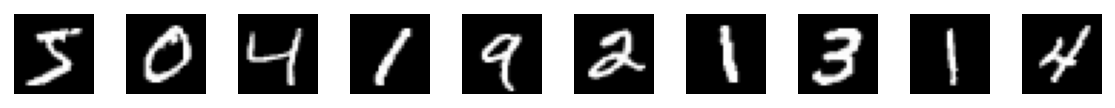

Permuted MNIST data:


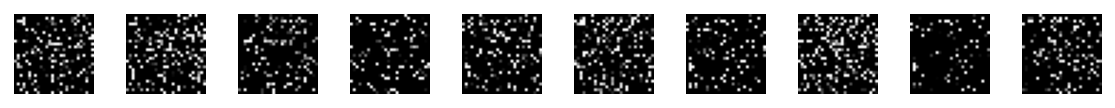

In [125]:
# Load in MNIST and create an additional permuted dataset
x_train, t_train, x_test, t_test = load_mnist(verbose=True)
x_train2, x_test2 = permute_mnist([x_train, x_test], 0, verbose=True)

# Plot the data to see what we're working with
print('MNIST Training data:')
plot_mnist(x_train, nPlots=10)
print('Permuted MNIST data:')
plot_mnist(x_train2, nPlots=10)


Great! We have our data, now let's define and train a model on the standard MNIST dataset and make sure everyting is working properly

In [137]:
# Define a new model and set params
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model on MNIST
nEpochs = 3
for epoch in range(1, nEpochs+1):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 1.478136
Test set: Average loss: 0.0004, Accuracy: 8375/10000 (84%)

Train Epoch: 2 	Loss: 1.013738
Test set: Average loss: 0.0002, Accuracy: 8861/10000 (89%)

Train Epoch: 3 	Loss: 1.336807
Test set: Average loss: 0.0003, Accuracy: 8808/10000 (88%)



Okay great! It seems we get decent accuracy on standard MNIST which means the model is learning the dataset. Now, a reasonable assumption is that, like humans, once the network learns something, it can aggregate it's knowledge and learn something else. We can try this by teaching the model the new permuted dataset that we built. First though, let's get a baseline for how the model performs on each of the two datasets. 

Testing on the task 1
Test set: Average loss: 0.0003, Accuracy: 8808/10000 (88%)

Testing on the task 2
Test set: Average loss: 0.0018, Accuracy: 865/10000 (9%)



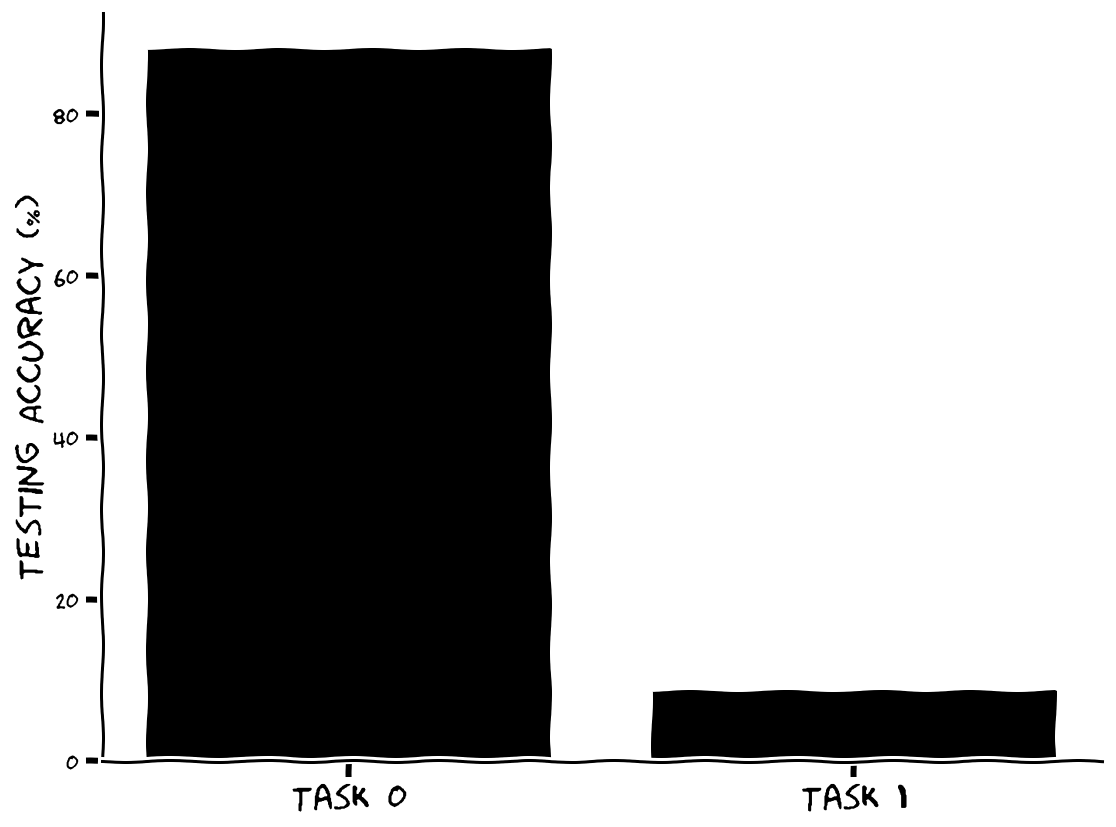

In [145]:
# test the model on both the regular and permuted dataset

# TODO: Refactor and move 
tasks = [(x_test, t_test), (x_test2, t_test)]
accs = []
for ti, task in enumerate(tasks):
  print(f"Testing on task {ti+1}")
  accs.append(test(model, device, task[0], task[1]))

# And then let's [plot it
with plt.xkcd():  
  
  nTasks = len(accs)
  plt.bar(range(nTasks), accs, color='k')
  plt.ylabel('Testing Accuracy (%)', size=18)
  plt.xticks(range(nTasks), 
             [f'Task {ii+1}' for ii in range(nTasks)], size=18)




As we saw before, the model does great on the dataset it was trained on, but not so well on the new one. No worries just yet though, we havn't taught it the new dataset yet! So let's train the same model on the new data, and see if we can get comparable performance between the two types of MNIST

Train Epoch: 1 	Loss: 1.281639
Test set: Average loss: 0.0005, Accuracy: 7757/10000 (78%)

Train Epoch: 2 	Loss: 1.297845
Test set: Average loss: 0.0004, Accuracy: 7943/10000 (79%)

Testing on task 1
Test set: Average loss: 0.0024, Accuracy: 948/10000 (9%)

Testing on task 2
Test set: Average loss: 0.0004, Accuracy: 7943/10000 (79%)



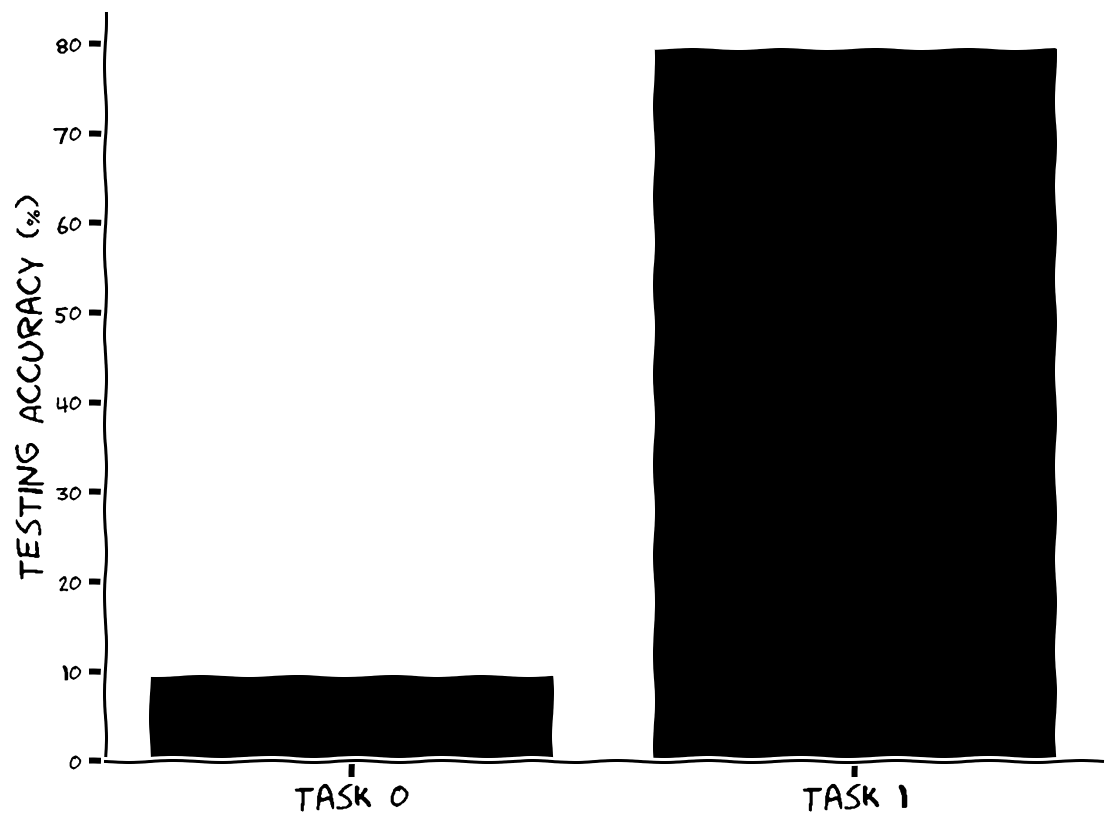

In [147]:

# Train the model on the new dataset
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)


# TODO: Refactor and move 
# Test the model on both datasets
tasks = [(x_test, t_test), (x_test2, t_test)]
accs = []
for ti, task in enumerate(tasks):
  print(f"Testing on task {ti+1}")
  accs.append(test(model, device, task[0], task[1]))

# And then let's plot it
with plt.xkcd():  
  
  nTasks = len(accs)
  plt.bar(range(nTasks), accs, color='k')
  plt.ylabel('Testing Accuracy (%)', size=18)
  plt.xticks(range(nTasks), 
             [f'Task {ii+1}' for ii in range(nTasks)], size=18)

Hey! Training did the trick, task 2 (permuted MNIST) has great accuracy now that we trained the model on it. But something is wrong. We just saw that Task 1 (standard MNIST) had high accuracy before we trained on the new task. What gives? 

### Exercise 1: Helpful exercise name (ex. fitting a linear regression model)

This exercise fits in this subsection so is a level 3 header

Very briefly summarize the exercise here. In this exercise, you will also invoke `multiply_array` which multiplies an array by a scalar

In [80]:
def generic_function(x):
  """Google style doc string. Brief summary of what function does here
  
  Args:
    x (ndarray): An array of shape (N,) that contains blah blah

  Returns:
    ndarray: The output is blah blah
  """
  #################################################
  ## TODO for students: details of what they should do ##
  # Fill out function and remove
  raise NotImplementedError("Student exercise: say what they should have done")
  #################################################
  
  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(..., 5)

  # Another comment because they need to add another line of code
  z = ...

  return z

x = np.array([4, 5, 6])
z = generic_function(x)

# we usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code
plotting_z(z)

NotImplementedError: ignored

---
__Editor guideline for exercise solution formatting:__
- the presence of # to_remove solution in the first line of solution block
- The absence of the fenced (#####) block that raises a NotImplementedError
- Valid code replacing all ellipses  (...)
- Code that uses or depends on the completed function/lines is uncommented
- Plotting code is indented under a with plt.xkcd(): context manager.
- **All other comments and code should be identical**
---

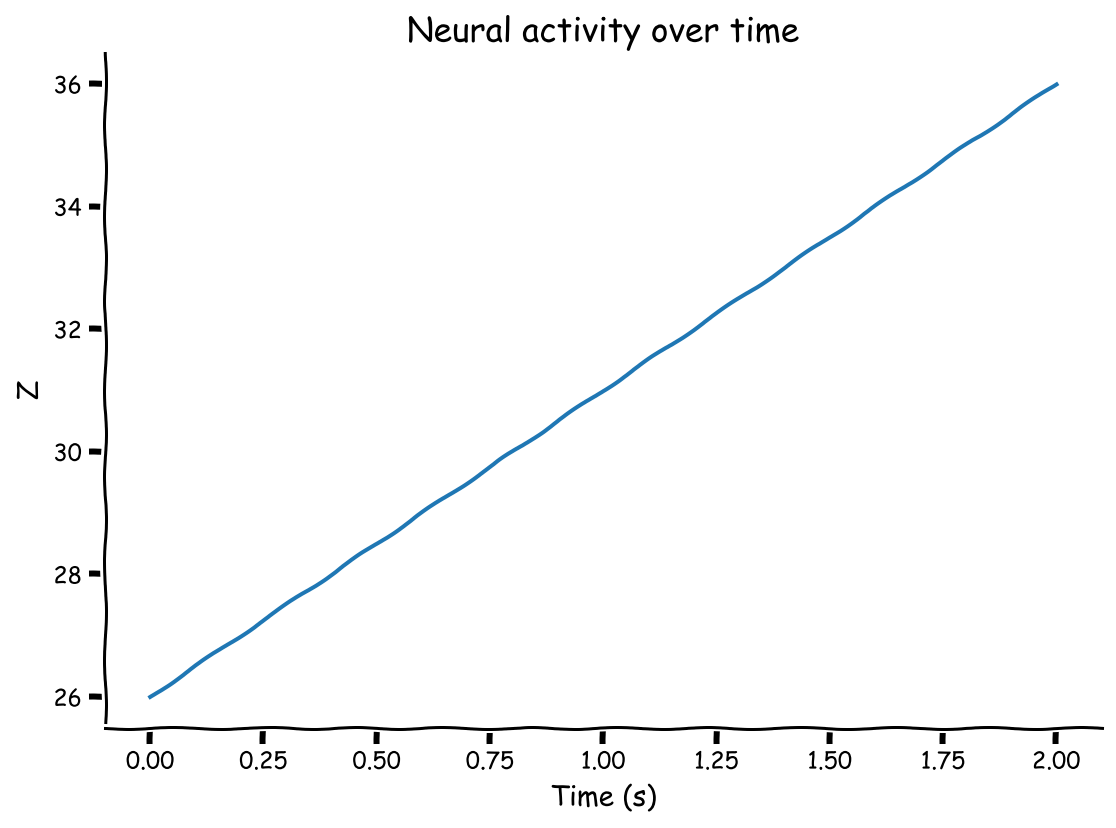

In [ ]:
# to_remove solution
def generic_function(x):
  """Google style doc string. Brief summary of what function does here
  
  Args:
    x (ndarray): An array of shape (N,) that contains blah blah

  Returns:
    ndarray: The output is blah blah
  """

  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(x, 5)

  # Another comment because they need to add another line of code
  z = y + 6

  return z

x = np.array([4, 5, 6])
z = generic_function(x)

# we usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code
# xkcd style for solution plot
with plt.xkcd():  
  plotting_z(z)

### Interactive Demo: Name of demo

Here, we will demonstrate how to create a widget if you would like to use a widget to demonstrate something. Make sure the use a @title cell and hide the contents by default, because the code to make the widget is often pretty ugly and not important for the students to see. Also, we recommend giving specific guidance for what students should look at with widget/what questions they're trying to answer so it's not just pointless twiddling.

If the widget makes use of a function that must be completed as part of an exercise, you may want to re-implement the correct version of the function inside the widget cell, so that it is useful for a student who got completely stuck.


In [7]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

x = np.arange(-10, 11, 0.1)

def gaussian(x, mu, sigma):
  px = np.exp(-1 / 2 / sigma**2 * (mu - x) ** 2)
  px = px / px.sum()
  return px

@widgets.interact
def plot_gaussian(mean=(-10, 10, .5), std=(.5, 10, .5)):
  plt.plot(x, gaussian(x, mean, std))


interactive(children=(FloatSlider(value=0.0, description='mean', max=10.0, min=-10.0, step=0.5), FloatSlider(v…

In [ ]:
# to_remove explanation

"""
Discussion: Write a dicussion about/answers to any open-ended questions you pose (either about a demo or elsewhere)

You can write a paragraph or two of nice didactic text
within a single comment. 
""";

__Editor guideline:__ note that the form header for the cell above is __to_remove explanation__, not __to_remove solution__.

maybe some more text about what exercises showed (if helpful). 
The Gaussian is: 
- bumpy in the middle
- symmetric
- almighty

## Section 1.2: Name

### Exercise 2: Name

---
# Section 2: Continual Learning strategies

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


## Exercise 3: Name

This exercise is in this section (not in a subsection) so has a level 2 header

### Exercise 2: Name

---
# Section 3: Continual learning benchmarks

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


## Exercise n: Name

This exercise is in this section (not in a subsection) so has a level 2 header

---
# Section 4: Evaluation of continual learning algorithms

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


## Exercise n: Name

This exercise is in this section (not in a subsection) so has a level 2 header

---
# Section 5: Continual Learning Applications

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


## Exercise n: Name

This exercise is in this section (not in a subsection) so has a level 2 header

---
# Bonus

Add extra text that you want students to have for reference later but that will make reading times too long during tutorials

In [ ]:
# Free up resources when done :)

import os, signal
os.kill(os.getpid(), signal.SIGKILL)